**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

*All the text in italics is instructions for filling the template - remove when writing the project report!*

# *Title* 

*Title should be concise and informative, describes the approach to solve the problem. Some good titles from previous years:*

*- Comparing extreme learning machines and naive bayes’ classifier in spam detection*

*- Using linear discriminant analysis in spam detection*

*Some not-so-good titles:*

*- Bayesian spam filtering with extras*

*- Two-component classifier for spam detection*

*- CS-E3210 Term Project, final report*




## Abstract

*Precise summary of the whole report, previews the contents and results. Must be a single paragraph between 100 and 200 words.*



## 1. Introduction (SMEDS)

*Background, problem statement, motivation, many references, description of
contents. Introduces the reader to the topic and the broad context within which your
research/project fits*

*- What do you hope to learn from the project?*
*- What question is being addressed?*
*- Why is this task important? (motivation)*

*Keep it short (half to 1 page).*

.-.-.-.-.-.-.-.-

Assigning a genre to a song is a task at which even humans might have different opinions as to what is the correct genre. Thus we can expect that teaching a computer to correctly predict a genre for a given song is no easy feat.

Our task is to teach a computer to assign a genre to a song, based on data extracted from the song. The two most important outcomes from this project are

1. How well can a computer predict the genre of a song based on simple Machine Learning algorithms
2. Can we generalize the problem to gain an understanding of how well we can classify other real-world 

We have two datasets consisting of song features, with one of the datasets being labeled to specific genres. Depending on the bitrate and audio format a single song can be several tens of megabytes, with normal listening bitrate for an mp3-file requiring at least a few megabytes. This means that using all bits in the song would result in a huge dataset impractical for our purposes.

Luckily our dataset has the songs preprocessed into vectors of 264 features. The features contain information about the rhytm pattern, chroma and Mel Frequency Cepstral Coefficients (MFFC). Further understanding of the vectors is not needed for this project.

## 2. Data analysis (FONTELL)

*Briefly describe data (class distribution, dimensionality) and how will it affect
classification. Visualize the data. Don’t focus too much on the meaning of the features,
unless you want to.*

*- Include histograms showing class distribution.*



In [11]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA


In [12]:
# Load the data and cleanup
train_data = pd.read_csv("train_data.csv", header=None).as_matrix()
test_data = pd.read_csv("test_data.csv", header=None).as_matrix()
train_labels = pd.read_csv("train_labels.csv", header=None).as_matrix()

Upon closer inspection of the data we see that many columns seem to have bad data. 
For example column with index 204 has mostly ones and column with index 216 is almost all 1E+06.
In the cell below we remove the coumns having bad data.

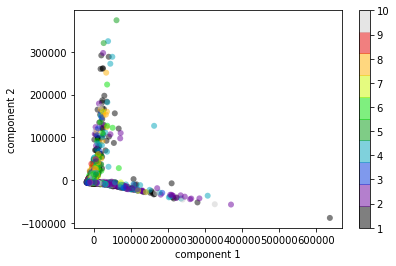

In [13]:
principal_components = pca.fit_transform(train_data)

plot_principal_components = np.column_stack((principal_components, train_labels))

plt.scatter(plot_principal_components[:, 0], plot_principal_components[:, 1],
            c=train_labels.ravel(), edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();



(4363, 264) (6544, 264) (4363, 1)
[1 1 1 ... 2 5 2]


(array([2178.,  618.,  326.,  253.,  214.,  260.,  141.,  195.,   92.,
          86.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

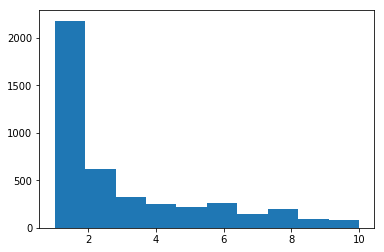

In [15]:
#Analysddis of the input data: MATTE
print(train_data.shape, test_data.shape, train_labels.shape)



#Histogram of class distribution

#class_labels = ['Pop_Rock', 'Electronic', 'Rap', 'Jazz', 'Latin', 'RnB', 'International', 'Country', 'Reggae', 'Blues']
labels_mat = train_labels # convert the data frame to numpy matrix
print(labels_mat[:,0])
plt.hist(labels_mat[:,0])
#plt.show()


In [18]:
#Analysis of the input data: MATTI


#TODO: divide data training data and labels into two halves - one for training, the other for validation
#TODO: Counteract imbalance in data set

traindata_mat = train_data # convert the data frame to numpy matrix
testdata_mat = test_data # convert the data frame to numpy matrix

N=traindata_mat.shape[0]
C = np.dot(traindata_mat.transpose(), traindata_mat)/float(N)
values, vectors = np.linalg.eig(C)
idx = (values.real).argsort()[::-1]   
values_sorted = (values[idx]).real
vectors_sorted = vectors[:,idx]

#test principal component analysis of data
pca=PCA(n_components = 20)
pca.fit(traindata_mat)
traindata_PCA=pca.transform(traindata_mat)
testdata_PCA=pca.transform(testdata_mat)
print(traindata_PCA.shape)

(4363, 20)


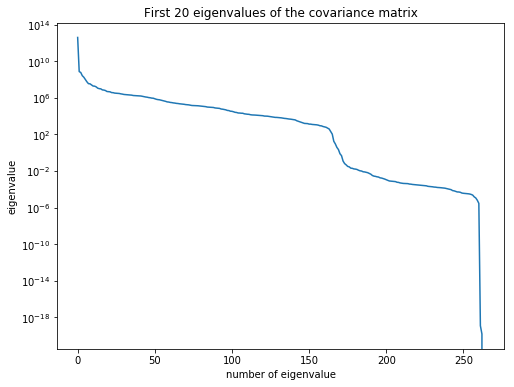

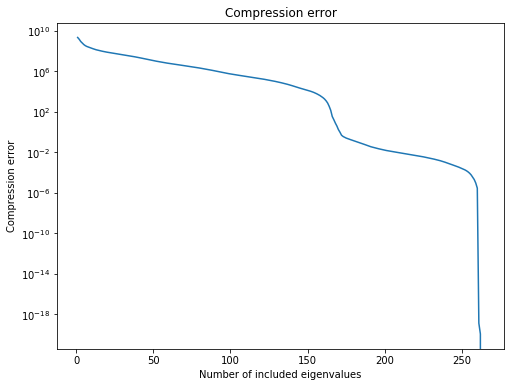

In [19]:
fig=plt.figure(figsize=(8,6))
plt.plot(values_sorted[:])
plt.xlabel('number of eigenvalue')
plt.semilogy()
plt.ylabel('eigenvalue')
plt.title("First 20 eigenvalues of the covariance matrix")
plt.show()

D=values_sorted.shape[0]
compression_error=np.zeros((1,D))
number_included=np.zeros((1,D))
for i in range(D):
    sum=0
    for j in range(i+1,D):
        sum+=values_sorted[j]
    compression_error[0,i]=sum
    number_included[0,i]=i+1
  
fig=plt.figure(figsize=(8,6))
plt.plot(number_included[0,:],compression_error[0,:])
plt.xlabel('Number of included eigenvalues')
plt.semilogy()
plt.ylabel('Compression error')
plt.title("Compression error")
plt.show()

## 3. Methods and experiments (MATTE)

*- Explain your whole approach (you can include a block diagram showing the steps in your process).* 

*- What methods/algorithms, why were the methods chosen. *

*- What evaluation methodology (cross CV, etc.).*



In [9]:
# Trials with ML algorithms

#TODO
#Polynomial regression

#Mattes algoritmer
#Try 1, LinearRegression
classifier_1 = linear_model.LinearRegression().fit(train_data_cleaned, train_labels)
score1 = classifier_1.score(train_data_cleaned, train_labels)
classifier_1.predict(test_data_cleaned)

#Try 2, SVM
#classifier_2 = SVC(gamma='auto')
#classifier_2.fit(train_data, train_labels.values.ravel())
#classifier_2.score(train_data, train_labels.values.ravel())

#Try 3, Deep learning
classifier_3 = MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=(5, 2), random_state=1)
classifier_3.fit(train_data_cleaned, train_labels.values.ravel())
score3 = classifier_3.score(train_data_cleaned, train_labels.values.ravel())

#Try 4, Bayesian Ridge regression
classifier_4 = linear_model.BayesianRidge().fit(train_data_cleaned, train_labels.values.ravel())
score4 = classifier_4.score(train_data_cleaned, train_labels.values.ravel())

#Try 5, Random Forest
classifier_5 = RandomForestClassifier(n_estimators=100, max_depth = 10).fit(train_data_cleaned, train_labels.values.ravel())
score5 = classifier_5.score(train_data_cleaned, train_labels.values.ravel())
classifier_5_output = classifier_5.predict(test_data_cleaned)
classifier_5_output_logloss = classifier_5.predict_proba(test_data_cleaned)


#Output
print("Linear regression score: ", score1)
print("Deep learning score: ", score3)
print("Bayesian Ridge Regression score: ", score4)
print("Random Forest score: ", score5)


Linear regression score:  0.33223979956167965
Deep learning score:  0.49919779967911987
Bayesian Ridge Regression score:  0.2488757358386392
Random Forest score:  0.8542287416914967


In [4]:
#Mattis algoritmer
#Try the same as above, but for the reduced data

classifier_5_reduced = RandomForestClassifier(n_estimators=10, max_depth = 10).fit(traindata_PCA, train_labels.values.ravel())
score5_reduced = classifier_5_reduced.score(traindata_PCA, train_labels.values.ravel())
classifier_5_reduced_output = classifier_5_reduced.predict(testdata_PCA)


#Output
print("Random Forest score with PCA compression, boom: ", score5_reduced)



Random Forest score with PCA compression, boom:  0.7779051111620444


## 4. Results (Output: Smeds, Confusion matrix: Fontell)

*Summarize the results of the experiments without discussing their implications.*

*- Include both performance measures (accuracy and LogLoss).*

*- How does it perform on kaggle compared to the train data.*

*- Include a confusion matrix.*



In [13]:
#Confusion matrix ...

#Output for Accuracy competition
output_csv = pd.DataFrame({'Sample_label': classifier_5_output})
output_csv.index += 1
output_csv.index.names = ['Sample_id']

#Output for Logloss competition
output_csv2 = pd.DataFrame(classifier_5_output_logloss, columns=['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5','Class_6','Class_7','Class_8','Class_9','Class_10',])
output_csv2.index += 1
output_csv2.index.names = ['Sample_id']

#output_csv.rename({1: "Sample_id", 2: "Sample_label"}, index=)
output_csv.to_csv('upload_to_kaggle_accuracy.csv')
output_csv2.to_csv('upload_to_kaggle_logloss.csv')


## 5. Discussion/Conclusions

*Interpret and explain your results *

*- Discuss the relevance of the performance measures (accuracy and LogLoss) for
imbalanced multiclass datasets. *

*- How the results relate to the literature. *

*- Suggestions for future research/improvement. *

*- Did the study answer your questions? *



## 6. References

*List of all the references cited in the document*

## Appendix
*Any additional material needed to complete the report can be included here. For example, if you want to keep  additional source code, additional images or plots, mathematical derivations, etc. The content should be relevant to the report and should help explain or visualize something mentioned earlier. **You can remove the whole Appendix section if there is no need for it.** *